In [246]:
#파이토치 인스톨
!pip install torch torchvision
import torch
print(torch.__version__)

1.5.0+cu101


In [247]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#실험결과 비교를 위해 시드 고정
seed = 444
np.random.seed(seed)
torch.manual_seed(seed)

In [0]:
class proData:
    
    #데이터 쪼개기, 학습, 평가, 테스트 3개부분으로
    def splitData(self,x,y):
        origin = len(x)
        trainn = int(origin*0.8)
        valn = int(origin*0.9)

        # 경향성을 없애기 위한 셔플
        s = np.arange(x.shape[0])
        np.random.shuffle(s)
        x = x[s]
        y = y[s]

        trainX, trainY = x[:trainn, :], y[:trainn]
        valX, valY = x[trainn:valn,:], y[trainn:valn]
        testX,testY = x[valn:,:], y[valn:]

        return trainX,trainY,valX,valY,testX,testY

In [0]:
import torch.nn as nn
# 모델 정의
    
class MLPModel(nn.Module):
    # input = 입력값 개수, output = 출력값 개수
    def __init__(self,_input,_output,_hidden_layers): 
        super(MLPModel, self).__init__()
        self.inputv = _input
        self.outputv = _output
        nodes = [_input] + _hidden_layers + [_output]
        self.depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(self.depth-1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        for linear in self.linears[:-1]: 
          x = linear(x)
          x = self.relu(x)
        x = self.linears[-1](x)

        return x

In [0]:
class epochClass():

    def __init__(self,_model,_optimizer,_device):
        self.model = _model
        self.optimizer = _optimizer
        self.reg_loss = nn.MSELoss()
        self.device = _device
        self.list_epoch = []
        self.list_val_loss = []
        self.list_mae = []
        self.list_mae_epoch = []

    def getModelOptim(self):
        return self.model, self.optimizer

    def getEpochList(self):
        return self.list_epoch, self.list_val_loss, self.list_mae, self.list_mae_epoch

    def startEpoch(self,epoch,interval,train_X,train_y,val_X,val_y,test_X,test_y):
    

        for i in range(epoch):    
            # ====== Train ====== #
            self.model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 
            self.optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
            
            input_x = torch.Tensor(train_X)
            true_y = torch.Tensor(train_y)
            #Gpu로 데이터 옮기기
            input_x = input_x.to(device)
            true_y = true_y.to(device)
            #
            pred_y = self.model(input_x)
            #
            
            loss = self.reg_loss(pred_y.squeeze(), true_y)
            loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
            self.optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
            self.list_epoch.append(i)
            
            # ====== Validation ====== #
            self.model.eval()
            self.optimizer.zero_grad()
            input_x = torch.Tensor(val_X)
            true_y = torch.Tensor(val_y)
            #GPU로 데이터 옮기기
            input_x = input_x.to(device)
            true_y = true_y.to(device)
            #
            pred_y = self.model(input_x)   
            loss = self.reg_loss(pred_y.squeeze(), true_y)
            self.list_val_loss.append(loss.item())
            

            # ====== Evaluation ======= #
            if i % interval == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
                
                # ====== Calculate MAE ====== #
                self.model.eval()
                self.optimizer.zero_grad()
                input_x = torch.Tensor(test_X)
                true_y = torch.Tensor(test_y)
                #
                input_x = input_x.to(device)
                true_y = true_y.to(device)
                #
                pred_y = self.model(input_x)
                mae = self.reg_loss(true_y, pred_y)
                self.list_mae.append(mae)
                self.list_mae_epoch.append(i)
                
                print(i, mae)

In [251]:
from google.colab import drive
drive.mount('/content/gdrive')

class DataLoader():
    
    def fileload(self,PATH):
        x = []
        y = []
        with open(PATH,'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line[:-1]
                temp = line.split(',')
                temp = temp[1:]
                x.append([int(temp[0]),int(temp[1]),int(temp[2]),int(temp[3]),int(temp[4])])
                y.append(int(temp[-1]))
        return x,y

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
d = DataLoader()
X = [] 
y = []
for i in range(12):
    xt, yt = d.fileload('/content/gdrive/My Drive/datas/data'+str(i)+'.txt')
    X = X + xt
    y = y + yt

In [253]:

inX = np.array(X)
iny = np.array(y).T

print(inX)
print(iny)
p = proData()
train_X, train_y, val_X, val_y, test_X, test_y = p.splitData(inX,iny)

[[    49250     48950     49250     48650  17793724]
 [    84100     84000     84400     83000   3652884]
 [   559000    500000    603000    494500   2991087]
 ...
 [     6680      6730      6860      6640 174171768]
 [   548000    555000    555000    541000      4905]
 [    19700     19950     20000     19550   1172863]]
[ 48300  81400 539000 ...   6575 545000  19800]


In [0]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
# 학습에 필요한 파라미터 정의

model = MLPModel(5,1,[200,150,100,50,25,10]) # Model을 생성해줍니다.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
#modelPath = '/content/gdrive/My Drive/model.pt'
#model.load_state_dict(torch.load(modelPath))
# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.Adam(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.


In [255]:
# 학습 시작
ep = epochClass(model,optimizer,device)
ep.startEpoch(20000,1000,train_X,train_y,val_X,val_y,test_X,test_y)

0 tensor(5.5604e+09, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1797, 1])) that is different to the input size (torch.Size([1797])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1000 tensor(7.8964e+09, device='cuda:0', grad_fn=<MeanBackward0>)
2000 tensor(7.8904e+09, device='cuda:0', grad_fn=<MeanBackward0>)
3000 tensor(7.8551e+09, device='cuda:0', grad_fn=<MeanBackward0>)
4000 tensor(7.8589e+09, device='cuda:0', grad_fn=<MeanBackward0>)
5000 tensor(7.9011e+09, device='cuda:0', grad_fn=<MeanBackward0>)
6000 tensor(7.8694e+09, device='cuda:0', grad_fn=<MeanBackward0>)
7000 tensor(7.8562e+09, device='cuda:0', grad_fn=<MeanBackward0>)
8000 tensor(7.8537e+09, device='cuda:0', grad_fn=<MeanBackward0>)
9000 tensor(7.8397e+09, device='cuda:0', grad_fn=<MeanBackward0>)
10000 tensor(7.7770e+09, device='cuda:0', grad_fn=<MeanBackward0>)
11000 tensor(7.8746e+09, device='cuda:0', grad_fn=<MeanBackward0>)
12000 tensor(7.8395e+09, device='cuda:0', grad_fn=<MeanBackward0>)
13000 tensor(7.9479e+09, device='cuda:0', grad_fn=<MeanBackward0>)
14000 tensor(7.9051e+09, device='cuda:0', grad_fn=<MeanBackward0>)
15000 tensor(7.8497e+09, device='cuda:0', grad_fn=<MeanBackward0>)
1600

In [0]:
# 학습결과 차트로 보여주기
list_epoch,list_val_loss,list_mae,list_mae_epoch = ep.getEpochList()


In [0]:
class pltClass():

    def __init__(self,_list_epoch, _list_val_loss, _list_mae_epoch, _list_mae):
        self.list_epoch = _list_epoch
        self.list_val_loss = _list_val_loss
        self.list_mae_epoch = _list_mae_epoch
        self.list_mae = _list_mae


    def printFigure(self):
        fig = plt.figure(figsize=(24,5))


        # ====== valid plot ====== #
        ax2 = fig.add_subplot(1, 2, 1)
        ax2.plot(self.list_epoch, self.list_val_loss, '--', label='val')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
        #ax1.set_ylim(0, 5)
        ax2.grid()
        ax2.legend()
        ax2.set_title('epoch vs loss')

        # ====== test plot ====== #
        ax3 = fig.add_subplot(1, 2, 2)
        ax3.plot(self.list_mae_epoch, self.list_mae, marker='x', label='test')

        ax3.set_xlabel('epoch')
        ax3.set_ylabel('mae')
        ax3.grid()
        ax3.legend()
        ax3.set_title('epoch vs loss')


        plt.show()



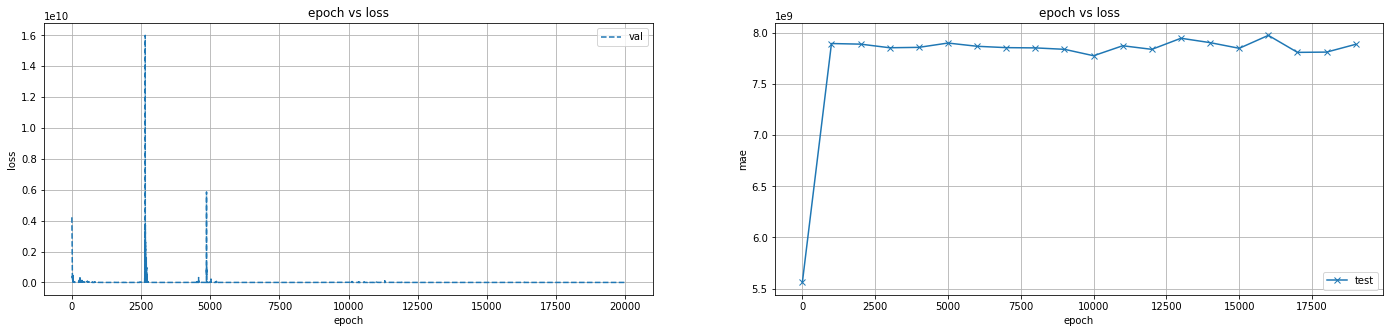

In [258]:

pltc = pltClass(list_epoch,list_val_loss,list_mae_epoch,list_mae)
pltc.printFigure()

In [259]:
model.to('cpu')
model.eval()

prediction = model(torch.Tensor(test_X))
pred = []
real = test_y
for i in prediction[:].T:
    for j in i:
        pred.append(j.item())


[50239.29296875, 16633.611328125, 1366.8594970703125, 17949.22265625, 7985.10595703125, 45427.05078125, 7201.60107421875, 9947.34375, 6912.6728515625, 2372.413330078125, 9982.6474609375, 12221.880859375, 3135.990478515625, 7200.06494140625, 7571.05078125, 31822.935546875, 4933.490234375, 1017.287109375, 2211.75244140625, 10599.3515625, 10053.2890625, 13694.509765625, 4886.3935546875, 10081.5068359375, 3620.767822265625, 125961.15625, 8949.771484375, 3916.860107421875, 4579.94287109375, 3361.258056640625, 35329.953125, 8442.78125, 1400.590087890625, 657160.625, 11656.5595703125, 104310.7421875, 618.1863403320312, 1212.6163330078125, 25036.408203125, 2800.64794921875, 8154.3935546875, 12321.05859375, 5280.06298828125, 7485.33837890625, 101877.5078125, 1366.6533203125, 14951.470703125, 12312.826171875, 19838.126953125, 162238.078125, 2959.42041015625, 10551.517578125, 4162.22021484375, 3174.96044921875, 26313.935546875, 3346.8408203125, 13753.1982421875, 11005.9423828125, 5052.33984375, 4

In [0]:

torch.save(model.state_dict(), modelPath)

Text(0.5, 1.0, 'pred vs real')

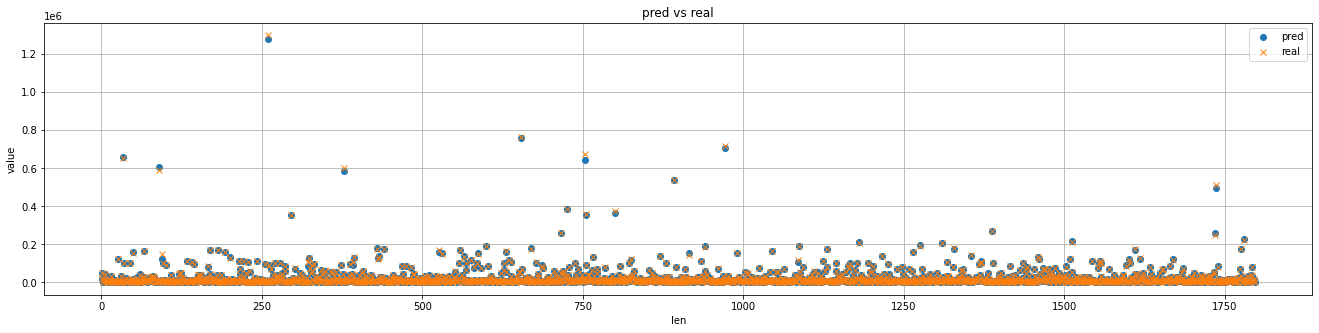

In [261]:
fig = plt.figure(figsize=(50,5))
xl = [n for n in range(1,len(pred)+1)]

# ====== valid plot ====== #
ax2 = fig.add_subplot(1, 2, 1)
ax2.plot(xl, pred, 'o', label='pred')
ax2.plot(xl, real, 'x', label='real')
ax2.set_xlabel('len')
ax2.set_ylabel('value')
#ax1.set_ylim(0, 5)
ax2.grid()
ax2.legend()
ax2.set_title('pred vs real')